## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

## Read in data

In [2]:
housing = pd.read_csv('data/boston_house_prices.csv')
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Update to a cross-validated approach


### TODO:
[x] Do a train-test split
[x] Do cross-validation and regularization
[ ] Estimate parameters using Bootstrapping

### Note about Github:

Generally we _don't_ write comments in code such as "replaced linear regression". We could, but if we use git logging system we should be able to tell what changed and revert back to it quickly.

In [3]:
features = housing.drop('MEDV', axis=1)
target = housing['MEDV']

In [4]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           random_state=42)

In [5]:
lasso_regressor = LassoCV()
lasso_regressor.fit(features_train, target_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [6]:
lasso_regressor.alpha_

0.7070114354536656

In [7]:
predicted_train = lasso_regressor.predict(features_train)

r2_score(target_train, predicted_train)

0.7145547249814624

Our previous $R^2$ was 0.740642664, so moving to LassoCV has actually done worse. 

We generally expect this (i.e. to do worse on the training set when we have regularization). The point of regularization is to do worse on the training set by making overfitting more difficult; hopefully we do better on the test set as a result and our model generalizes better. 

Let's look at the test set and see if this is the case:

In [8]:
predicted_test = lasso_regressor.predict(features_test)
r2_score(target_test, predicted_test)

0.6641778813398828

Ouch! 

This is signficantly worse than the adjusted R^2 from Excel!

We have made an error here (again, a deliberate one) but this one is more obvious than the typo. We will work on figuring out what is going on here before we merge back into the master branch, but let's commit this so the work doesn't accidentally get lost. (Note the error is that we didn't scale the features, and having numbers on very different scales means we don't trust our regularization or feature selection, but we are going to pretend we haven't caught that error yet)

While working on this, let's look at the coefficients of the `lasso_regressor`. It is common to use lasso (aka L1 regression) to do feature selection, as it tends to set the coefficients of unimportant features to zero (at least more aggressively than ridge does).

In [9]:
lasso_regressor.coef_

array([-0.0959547 ,  0.0288031 , -0.        ,  0.        , -0.        ,
        2.4186568 ,  0.00316663, -0.76132878,  0.21893286, -0.01165305,
       -0.7206268 ,  0.01267694, -0.69977059])

We see here that coefficients 2, 3, and 4 seem to be called out as unimportant. Let's arrange this by the absolute value of the coefficients. It is a little easier to see it we use the names as well, and sort by importance.

In [10]:
feature_importance = sorted(zip(lasso_regressor.coef_, features.columns), key=lambda x: abs(x[0]),
                           reverse=True)
for coef, name in feature_importance:
    print(f'{name:10s} {coef:6.4f}')

RM         2.4187
DIS        -0.7613
PTRATIO    -0.7206
LSTAT      -0.6998
RAD        0.2189
CRIM       -0.0960
ZN         0.0288
B          0.0127
TAX        -0.0117
AGE        0.0032
INDUS      -0.0000
CHAS       0.0000
NOX        -0.0000


## Plot of residuals

In Excel, we include a plot of residuals for every feature. We will do the same thing here

In [12]:
# Note this definition of residuals is actually off by a minus sign
# We will correct this in a later commit - this is a deliberate "mistake"
residuals = predicted_train - target_train

ValueError: x and y must have same first dimension, but have shapes (506,) and (379,)

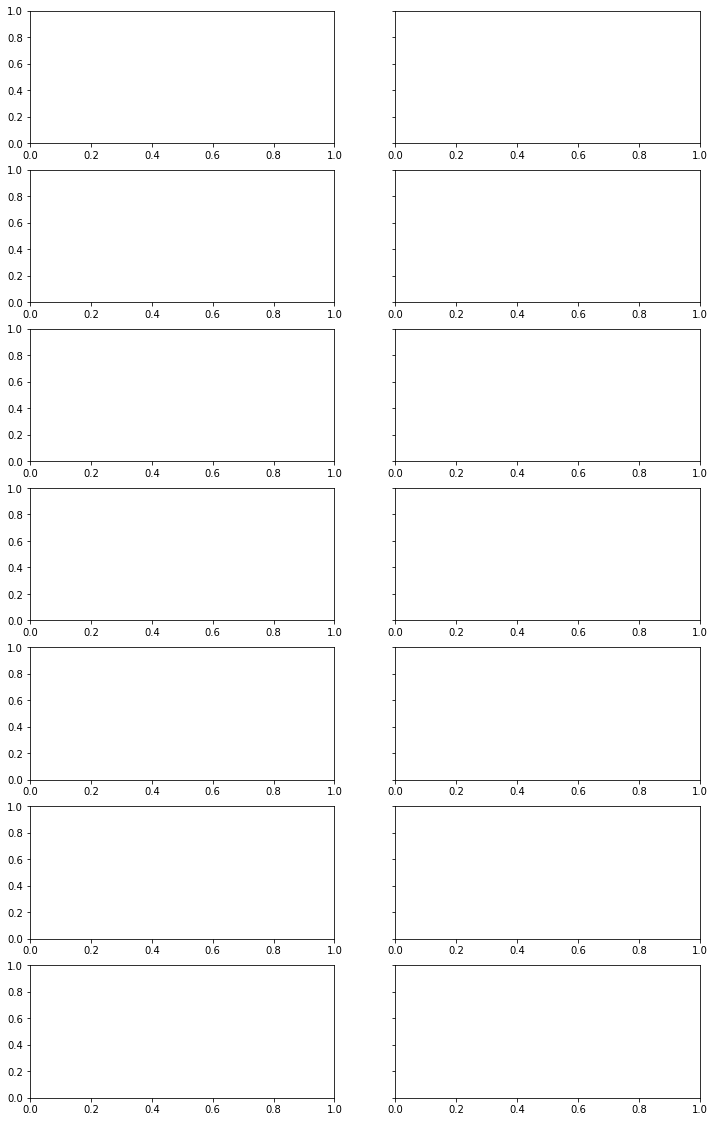

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=len(features.columns)//2 + 1, 
                         sharey=True, squeeze=True, figsize=(12,20))

for index, feature_name in enumerate(features.columns):
    feature_values = features[feature_name]
    col = index % 2
    row = index // 2
    this_plot = axes[row][col]
    this_plot.plot(feature_values, residuals, 'bo')
    this_plot.set_xlabel(feature_name)